# Omission LFP Analysis

Brief 1-2 sentence description of notebook.

In [230]:
import os
import glob
from collections import defaultdict

In [231]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [232]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
from spectral_connectivity import Multitaper, Connectivity

## Inputs & Data

Explanation of each input and where it comes from.

In [233]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
INPUT_VARIABLE = 1
CHANNEL_MAPPING_DF = pd.read_excel("../../channel_mapping.xlsx")
TONE_TIMESTAMP_DF = pd.read_excel("../../rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs
TIME_HALFBANDWIDTH_PRODUCT = 1
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.1
BRAIN_REGION_COL = ["spike_interface_mPFC",
"spike_interface_vHPC",
"spike_interface_BLA",
"spike_interface_LH",
"spike_interface_MD"]
TRIAL_TIME_STAMP_DURATION = 1000*10

In [329]:
all_session_dir = ['/scratch/back_up/reward_competition_extention/data/standard/2023_06_12/20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec',
'/scratch/back_up/reward_competition_extention/data/pilot/20221214_125409_om_and_comp_6_1_and_6_3.rec',
'/scratch/back_up/reward_competition_extention/data/pilot/20221215_145401_comp_amd_om_6_1_and_6_3.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec']

In [330]:
all_session_dir

['/scratch/back_up/reward_competition_extention/data/standard/2023_06_12/20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec',
 '/scratch/back_up/reward_competition_extention/data/pilot/20221214_125409_om_and_comp_6_1_and_6_3.rec',
 '/scratch/back_up/reward_competition_extention/data/pilot/20221215_145401_comp_amd_om_6_1_and_6_3.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec']

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

- Ideally functions are defined here first and then data is processed using the functions
    - function names are short and in snake case all lowercase
    - a function name should be unique but does not have to describe the function
    - doc strings describe functions not function names

In [331]:
def nested_dict():
    return defaultdict(nested_dict)

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [332]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

In [333]:
CHANNEL_MAPPING_DF

,Cohort,Subject,eib_mPFC,eib_vHPC,eib_BLA,eib_LH,eib_MD,spike_interface_mPFC,spike_interface_vHPC,spike_interface_BLA,spike_interface_LH,spike_interface_MD
0,1,6.1,NaN,15,14,13,31,21.0,15.0,14.0,13.0,16.0
1,1,6.2,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
2,1,6.3,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
3,1,6.4,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
4,2,1.1,NaN,16,17,18,19,5.0,31.0,30.0,29.0,28.0
5,2,1.2,NaN,31,30,29,28,10.0,31.0,30.0,29.0,28.0
6,2,1.3,NaN,15,14,13,12,9.0,31.0,30.0,29.0,28.0
7,2,1.4,NaN,15,14,13,12,15.0,31.0,30.0,29.0,28.0


In [334]:
all_trials_df = TONE_TIMESTAMP_DF.dropna(subset="condition").reset_index(drop=True)

In [335]:
sorted(all_trials_df["recording_dir"].unique())

['20221202_134600_omission_and_competition_subject_6_1_and_6_2',
 '20221203_154800_omission_and_competition_subject_6_4_and_6_1',
 '20221214_125409_om_and_comp_6_1_and_6_3',
 '20221215_145401_comp_amd_om_6_1_and_6_3',
 '20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3',
 '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1',
 '20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4',
 '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1',
 '20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2']

In [336]:
all_trials_df["resampled_index"] = all_trials_df["time_stamp_index"] // 20

In [337]:
all_trials_df["recording_dir"] = all_trials_df["recording_dir"].apply(lambda x: x if "2023" in x else "subj" + "_".join(x.split("_")[-5:]))

In [338]:
all_trials_df["all_subjects"] = all_trials_df["recording_dir"].apply(lambda x: sorted([num.strip("_").replace("_",".") for num in x.replace("-", "_").split("subj")[-1].strip("_").split("and")]))

In [339]:
all_trials_df["current_subject"] = all_trials_df["subject_info"].apply(lambda x: ".".join(x.replace("-","_").split("_")[:2]))

In [340]:
all_trials_df

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject
0,9781115.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,982229.0,20230612_101430_standard_comp_to_training_D1_s...,980.0,2.0,1-3_t3b3L_box2,1.4,Subj 2 Only,NaN,49111.0,"[1.3, 1.4]",1.3
1,12181113.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,3382227.0,20230612_101430_standard_comp_to_training_D1_s...,3376.0,2.0,1-3_t3b3L_box2,1.3,Subj 1 Only,NaN,169111.0,"[1.3, 1.4]",1.3
2,14481111.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,5682225.0,20230612_101430_standard_comp_to_training_D1_s...,5671.0,2.0,1-3_t3b3L_box2,1.4,Subj 2 Only,NaN,284111.0,"[1.3, 1.4]",1.3
3,16281110.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,7482224.0,20230612_101430_standard_comp_to_training_D1_s...,7468.0,2.0,1-3_t3b3L_box2,1.4,Subj 2 Only,NaN,374111.0,"[1.3, 1.4]",1.3
4,17381106.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,8582220.0,20230612_101430_standard_comp_to_training_D1_s...,8566.0,2.0,1-3_t3b3L_box2,1.4,Subj 2 Only,NaN,429111.0,"[1.3, 1.4]",1.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,56250471.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,53298568.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,60112.0,1.0,6_1_top_1_base_2_vs_6_3,6.3,Subj 2 Only,NaN,2664928.0,"[6.1, 6.3]",6.1
637,58050469.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,55098566.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,62355.0,1.0,6_1_top_1_base_2_vs_6_3,6.3,Subj 2 Only,NaN,2754928.0,"[6.1, 6.3]",6.1
638,59950467.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,56998564.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,64724.0,1.0,6_1_top_1_base_2_vs_6_3,6.1,Subj 1 Only,NaN,2849928.0,"[6.1, 6.3]",6.1
639,62350467.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,59398564.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,67716.0,1.0,6_1_top_1_base_2_vs_6_3,6.3,Subj 2 Only,NaN,2969928.0,"[6.1, 6.3]",6.1


In [341]:
all_trials_df["trial_outcome"] = all_trials_df.apply(
    lambda x: "win" if str(x["condition"]).strip() == str(x["current_subject"]) 
             else ("lose" if str(x["condition"]) in x["all_subjects"] 
                   else x["condition"]), axis=1)

In [342]:
all_trials_df

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome
0,9781115.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,982229.0,20230612_101430_standard_comp_to_training_D1_s...,980.0,2.0,1-3_t3b3L_box2,1.4,Subj 2 Only,NaN,49111.0,"[1.3, 1.4]",1.3,lose
1,12181113.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,3382227.0,20230612_101430_standard_comp_to_training_D1_s...,3376.0,2.0,1-3_t3b3L_box2,1.3,Subj 1 Only,NaN,169111.0,"[1.3, 1.4]",1.3,win
2,14481111.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,5682225.0,20230612_101430_standard_comp_to_training_D1_s...,5671.0,2.0,1-3_t3b3L_box2,1.4,Subj 2 Only,NaN,284111.0,"[1.3, 1.4]",1.3,lose
3,16281110.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,7482224.0,20230612_101430_standard_comp_to_training_D1_s...,7468.0,2.0,1-3_t3b3L_box2,1.4,Subj 2 Only,NaN,374111.0,"[1.3, 1.4]",1.3,lose
4,17381106.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,8582220.0,20230612_101430_standard_comp_to_training_D1_s...,8566.0,2.0,1-3_t3b3L_box2,1.4,Subj 2 Only,NaN,429111.0,"[1.3, 1.4]",1.3,lose
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,56250471.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,53298568.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,60112.0,1.0,6_1_top_1_base_2_vs_6_3,6.3,Subj 2 Only,NaN,2664928.0,"[6.1, 6.3]",6.1,lose
637,58050469.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,55098566.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,62355.0,1.0,6_1_top_1_base_2_vs_6_3,6.3,Subj 2 Only,NaN,2754928.0,"[6.1, 6.3]",6.1,lose
638,59950467.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,56998564.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,64724.0,1.0,6_1_top_1_base_2_vs_6_3,6.1,Subj 1 Only,NaN,2849928.0,"[6.1, 6.3]",6.1,win
639,62350467.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,59398564.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,67716.0,1.0,6_1_top_1_base_2_vs_6_3,6.3,Subj 2 Only,NaN,2969928.0,"[6.1, 6.3]",6.1,lose


In [347]:
recording_name_to_object = {}
for session_dir in all_session_dir:
    for recording_path in glob.glob(os.path.join(session_dir, "*.rec")):
        try:
            recording_basename = os.path.splitext(os.path.basename(recording_path))[0]
            current_recording = se.read_spikegadgets(recording_path, stream_id="ECU")
            current_recording = se.read_spikegadgets(recording_path, stream_id="trodes")
            print(recording_basename)
            current_recording = sp.bandpass_filter(current_recording, freq_min=0.5, freq_max=300)
            current_recording = sp.notch_filter(current_recording, freq=60)
            current_recording = sp.resample(current_recording, resample_rate=1000)
            recording_name_to_object[recording_basename] = current_recording
        except:
            pass



20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
20221215_145401_comp_amd_om_6_1_top_4_base_3
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged


In [348]:
all_trials_df = all_trials_df[all_trials_df["recording_file"].isin(recording_name_to_object.keys())].reset_index(drop=True)

In [349]:
all_trials_df

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome
0,9781115.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,982229.0,20230612_101430_standard_comp_to_training_D1_s...,980.0,2.0,1-3_t3b3L_box2,1.4,Subj 2 Only,NaN,49111.0,"[1.3, 1.4]",1.3,lose
1,12181113.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,3382227.0,20230612_101430_standard_comp_to_training_D1_s...,3376.0,2.0,1-3_t3b3L_box2,1.3,Subj 1 Only,NaN,169111.0,"[1.3, 1.4]",1.3,win
2,14481111.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,5682225.0,20230612_101430_standard_comp_to_training_D1_s...,5671.0,2.0,1-3_t3b3L_box2,1.4,Subj 2 Only,NaN,284111.0,"[1.3, 1.4]",1.3,lose
3,16281110.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,7482224.0,20230612_101430_standard_comp_to_training_D1_s...,7468.0,2.0,1-3_t3b3L_box2,1.4,Subj 2 Only,NaN,374111.0,"[1.3, 1.4]",1.3,lose
4,17381106.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,8582220.0,20230612_101430_standard_comp_to_training_D1_s...,8566.0,2.0,1-3_t3b3L_box2,1.4,Subj 2 Only,NaN,429111.0,"[1.3, 1.4]",1.3,lose
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,56250471.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,53298568.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,60112.0,1.0,6_1_top_1_base_2_vs_6_3,6.3,Subj 2 Only,NaN,2664928.0,"[6.1, 6.3]",6.1,lose
526,58050469.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,55098566.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,62355.0,1.0,6_1_top_1_base_2_vs_6_3,6.3,Subj 2 Only,NaN,2754928.0,"[6.1, 6.3]",6.1,lose
527,59950467.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,56998564.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,64724.0,1.0,6_1_top_1_base_2_vs_6_3,6.1,Subj 1 Only,NaN,2849928.0,"[6.1, 6.3]",6.1,win
528,62350467.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,59398564.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,67716.0,1.0,6_1_top_1_base_2_vs_6_3,6.3,Subj 2 Only,NaN,2969928.0,"[6.1, 6.3]",6.1,lose


In [350]:
all_trials_df["trial_outcome"].unique()

array(['lose', 'win', 'rewarded', 'omission'], dtype=object)

In [351]:
CHANNEL_MAPPING_DF

,Cohort,Subject,eib_mPFC,eib_vHPC,eib_BLA,eib_LH,eib_MD,spike_interface_mPFC,spike_interface_vHPC,spike_interface_BLA,spike_interface_LH,spike_interface_MD
0,1,6.1,NaN,15,14,13,31,21.0,15.0,14.0,13.0,16.0
1,1,6.2,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
2,1,6.3,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
3,1,6.4,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
4,2,1.1,NaN,16,17,18,19,5.0,31.0,30.0,29.0,28.0
5,2,1.2,NaN,31,30,29,28,10.0,31.0,30.0,29.0,28.0
6,2,1.3,NaN,15,14,13,12,9.0,31.0,30.0,29.0,28.0
7,2,1.4,NaN,15,14,13,12,15.0,31.0,30.0,29.0,28.0


In [358]:
recording_name_to_object.keys()

dict_keys(['20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged', '20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3', '20221215_145401_comp_amd_om_6_1_top_4_base_3', '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged', '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged'])

In [364]:
condition_to_everything = {}
for outcome in all_trials_df["trial_outcome"].unique():
    condition_to_everything[outcome] = defaultdict(lambda: defaultdict(list))
    outcome_df = all_trials_df[all_trials_df["trial_outcome"] == outcome]
    for recording_name, lfp_signal in recording_name_to_object.items():
        print(recording_name)
        if "6_1" in recording_name:
            current_subject = 6.1
        else:
            current_subject = float(".".join(recording_name.split("subject")[-1].split("subj")[-1].strip("merged").strip("_").replace("-","_").split("_")[:2]))
        current_channel_map = CHANNEL_MAPPING_DF[CHANNEL_MAPPING_DF["Subject"] == current_subject].iloc[0]
        current_trial_df = outcome_df[(outcome_df["recording_file"] == recording_name) & outcome_df["video_number"] == 1].reset_index(drop=True)
        for brain_region in brain_region_col:
            current_channel = str(int(current_channel_map[brain_region]))
            print(current_channel)
            for index, row in current_trial_df.iterrows():
                print(row["resampled_index"])
                current_trace = lfp_signal.get_traces(channel_ids=[current_channel], start_frame=row["resampled_index"], end_frame=row["resampled_index"] + 1000 * 10).T[0]
                # Compute multitaper spectral estimate
                m = Multitaper(time_series=current_trace,
                               sampling_frequency=1000)
                
                # Sets up computing connectivity measures/power from multitaper spectral estimate
                c = Connectivity.from_multitaper(m)
                condition_to_everything[outcome][brain_region.strip("spike_interface_")][recording_name].append(c.power().squeeze())

20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
15
169111.0
479111.0
649110.0
754110.0
804110.0
884110.0
949110.0
1014110.0
1134110.0
1309110.0
1379110.0
1489110.0
1549110.0
169111.0
479111.0
649110.0
754110.0
804110.0
884110.0
949110.0
1014110.0
1134110.0
1309110.0
1379110.0
1489110.0
1549110.0
31
169111.0
479111.0
649110.0
754110.0
804110.0
884110.0
949110.0
1014110.0
1134110.0
1309110.0
1379110.0
1489110.0
1549110.0
169111.0
479111.0
649110.0
754110.0
804110.0
884110.0
949110.0
1014110.0
1134110.0
1309110.0
1379110.0
1489110.0
1549110.0
30
169111.0
479111.0
649110.0
754110.0
804110.0
884110.0
949110.0
1014110.0
1134110.0
1309110.0
1379110.0
1489110.0
1549110.0
169111.0
479111.0
649110.0
754110.0
804110.0
884110.0
949110.0
1014110.0
1134110.0
1309110.0
1379110.0
1489110.0
1549110.0
29
169111.0
479111.0
649110.0
754110.0
804110.0
884110.0
949110.0
1014110.0
1134110.0
1309110.0
1379110.0
1489110.0
1549110.0
169111.0
479111.0
649110.0
754110.0
804110.0
884110.0
9

In [371]:
current_subject

1.1

In [372]:
CHANNEL_MAPPING_DF["Subject"]

0    6.1
1    6.2
2    6.3
3    6.4
4    1.1
5    1.2
6    1.3
7    1.4
Name: Subject, dtype: float64

In [373]:
recording_name

'20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged'

In [374]:
len(c.frequencies)

5000

In [375]:
np.vstack(current_trials).shape[0]

6

lose
mPFC
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(26, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(14, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(26, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(28, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(12, 5000)


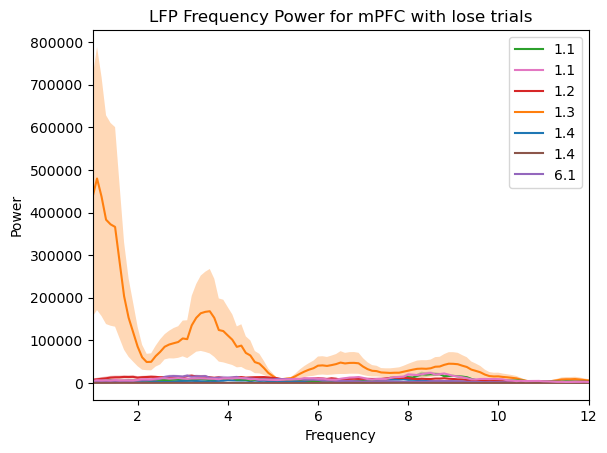

yay!
vHPC
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(26, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(14, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(26, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(28, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(12, 5000)


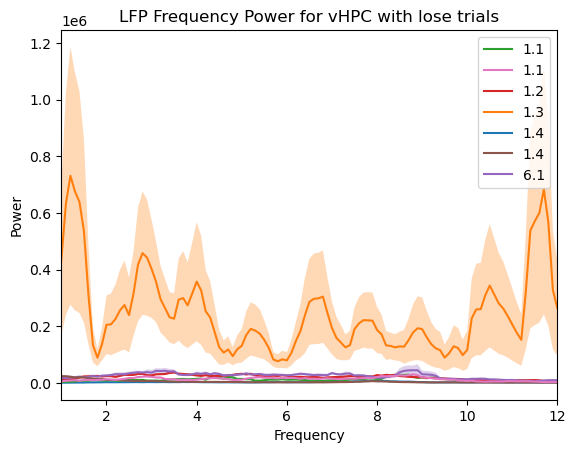

yay!
BLA
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(26, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(14, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(26, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(28, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(12, 5000)


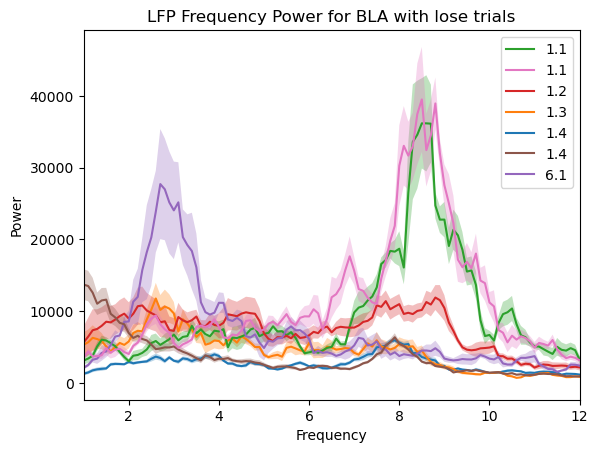

yay!
LH
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(26, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(14, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(26, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(28, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(12, 5000)


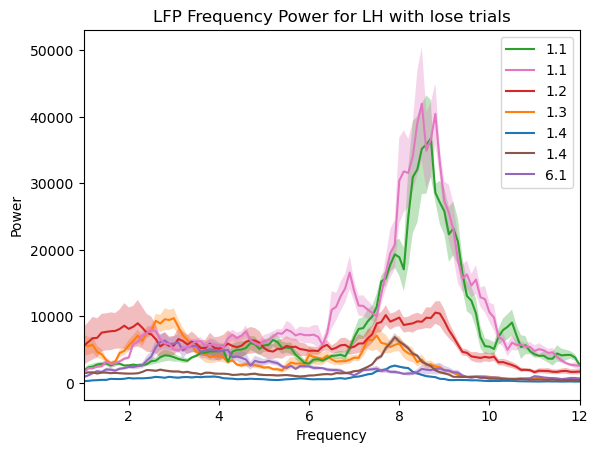

yay!
MD
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(26, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(14, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(26, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(28, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(12, 5000)


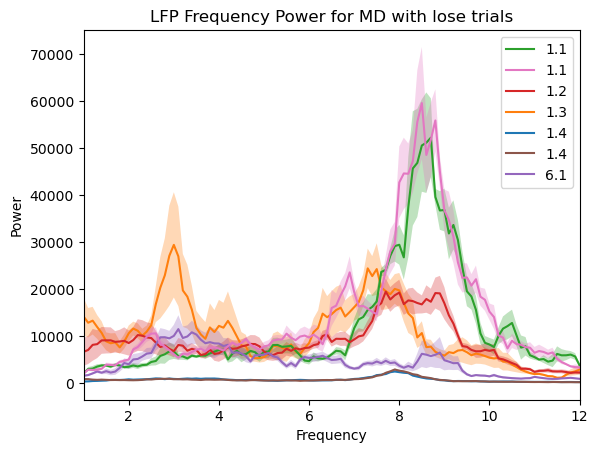

yay!
win
mPFC
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(14, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(13, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(19, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(12, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(28, 5000)


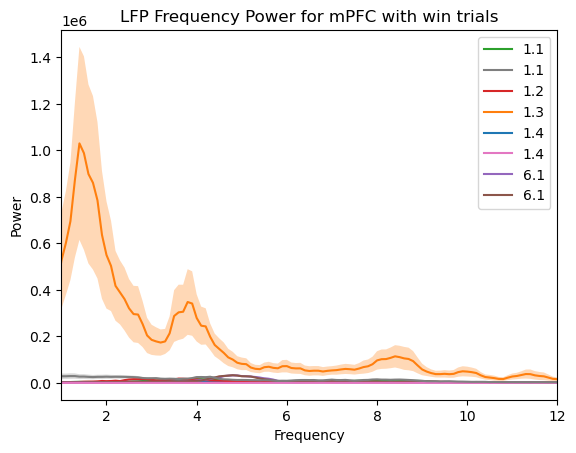

yay!
vHPC
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(14, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(13, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(19, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(12, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(28, 5000)


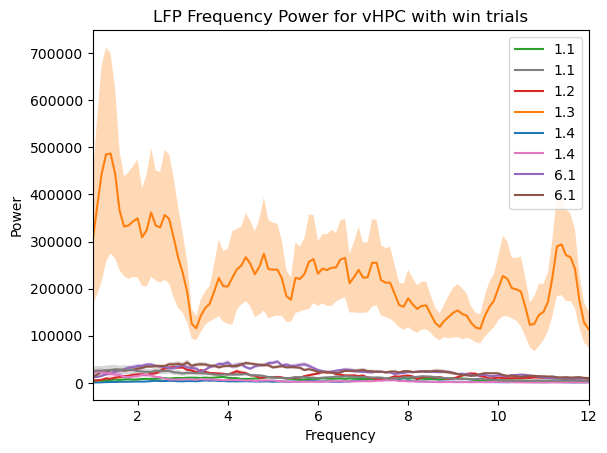

yay!
BLA
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(14, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(13, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(19, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(12, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(28, 5000)


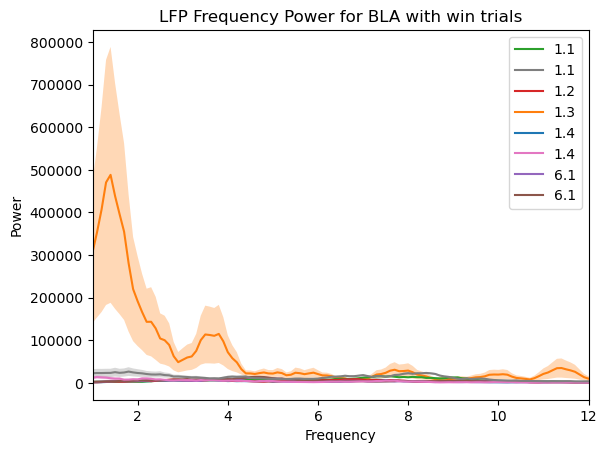

yay!
LH
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(14, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(13, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(19, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(12, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(28, 5000)


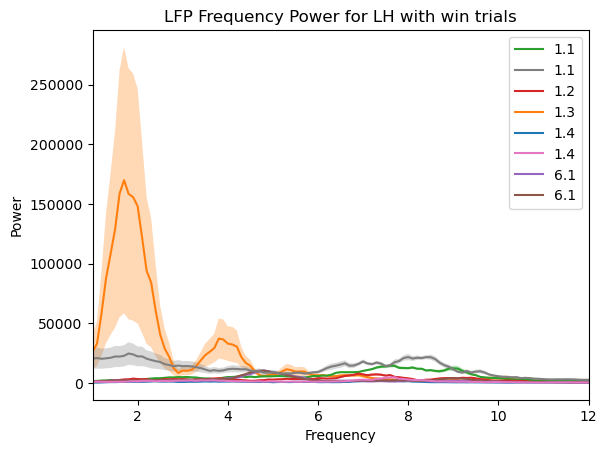

yay!
MD
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(14, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(13, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(19, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(12, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(28, 5000)


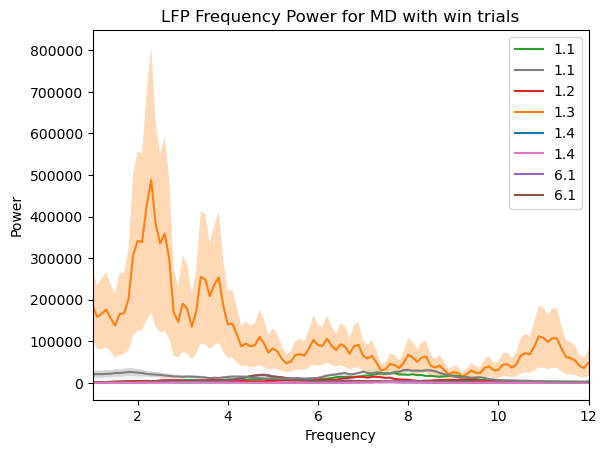

yay!
rewarded
mPFC
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(40, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(40, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(30, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(30, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(11, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(11, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(32, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(30, 5000)


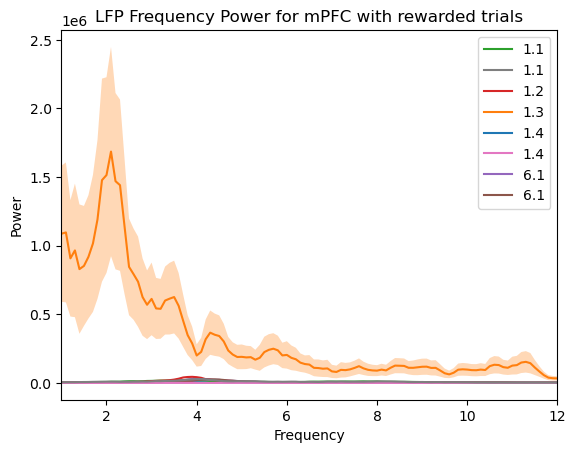

yay!
vHPC
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(40, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(40, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(30, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(30, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(11, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(11, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(32, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(30, 5000)


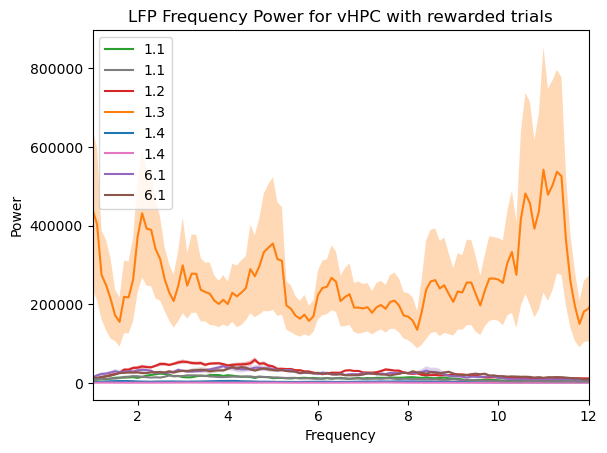

yay!
BLA
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(40, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(40, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(30, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(30, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(11, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(11, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(32, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(30, 5000)


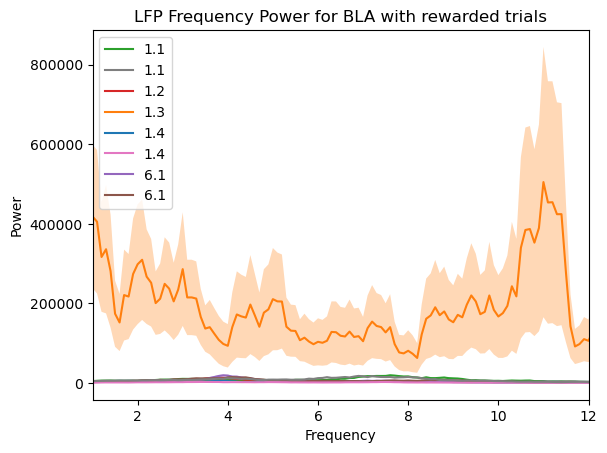

yay!
LH
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(40, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(40, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(30, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(30, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(11, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(11, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(32, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(30, 5000)


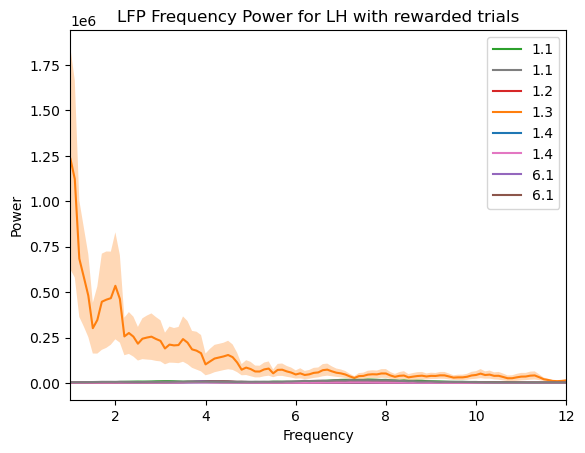

yay!
MD
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(40, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(40, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(30, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(30, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(11, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(11, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(32, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(30, 5000)


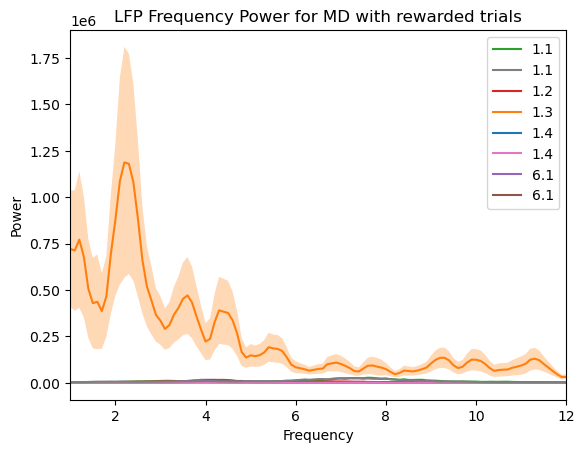

yay!
omission
mPFC
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(3, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(3, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(6, 5000)


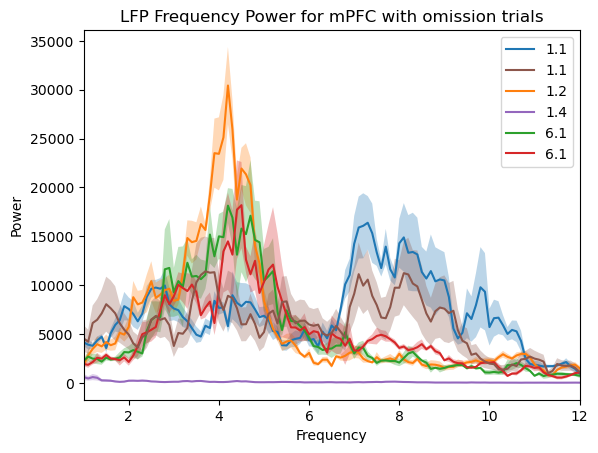

yay!
vHPC
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(3, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(3, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(6, 5000)


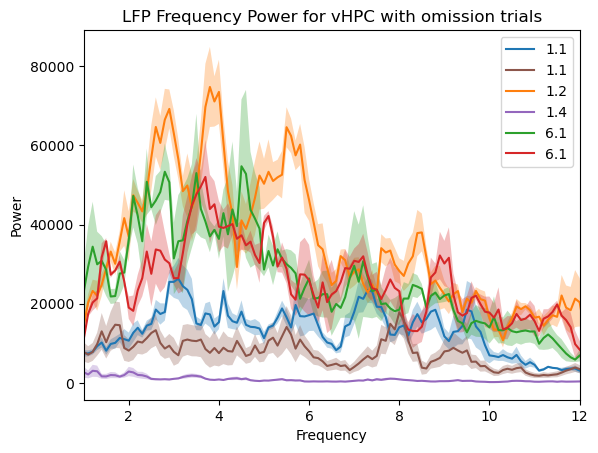

yay!
BLA
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(3, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(3, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(6, 5000)


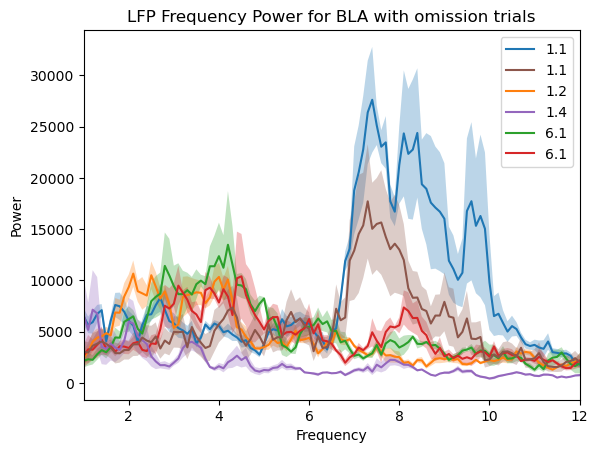

yay!
LH
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(3, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(3, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(6, 5000)


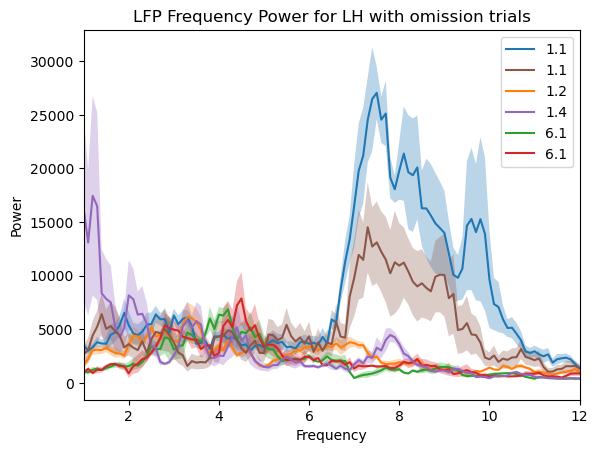

yay!
MD
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(3, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(3, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(6, 5000)


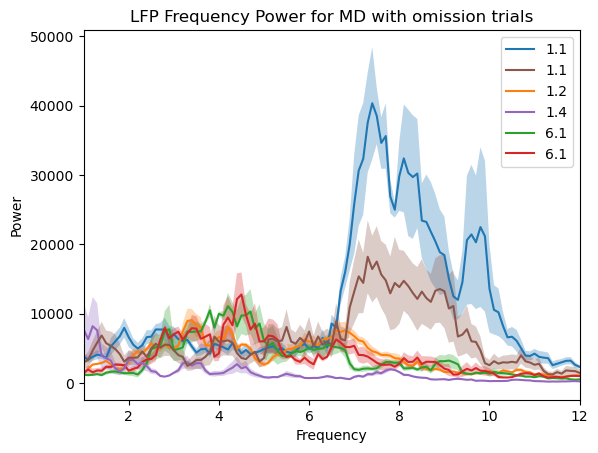

yay!


In [382]:
for outcome, all_region_dicts in condition_to_everything.items():
    print(outcome)
    
    for region, all_recording_dict in all_region_dicts.items():
        print(region)
        
        fig, ax = plt.subplots()
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Power")
        ax.set_xlim(1,12)
        # labelLines(ax.get_lines(), zorder=2.5)
        plt.title("LFP Frequency Power for {} with {} trials".format(region, outcome))
        for recording, all_trials in all_recording_dict.items():
            if "6_1" in recording:
                subject = "6.1"
            else:
                subject = ".".join(recording.split("subject")[-1].split("subj")[-1].strip("merged").strip("_").replace("-","_").split("_")[:2])
            current_trials = [trials for trials in all_trials if len(trials) == 5000] 
            print(recording)
            print(np.vstack(current_trials).shape)

            mean_power = np.mean(np.vstack(current_trials), axis=0)
            sem_power = np.std(np.vstack(current_trials), axis=0) / np.sqrt(np.vstack(current_trials).shape[0])

            plt.plot(c.frequencies, mean_power, label=subject)
            plt.fill_between(c.frequencies, mean_power - sem_power, mean_power + sem_power, alpha=0.3)
        # Get the handles and labels from the current axes
        handles, labels = plt.gca().get_legend_handles_labels()
        
        # Sort them by labels
        sorted_handles_labels = sorted(zip(handles, labels), key=lambda t: t[1])
        
        # Unzip them back
        sorted_handles, sorted_labels = zip(*sorted_handles_labels)
        
        # Display the legend
        plt.legend(sorted_handles, sorted_labels)
        plt.savefig("./proc/lfp_power_{}_{}.png".format(outcome, region))
        plt.show()
        print("yay!")
            

lose
mPFC
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(26, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(14, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(26, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(28, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(12, 5000)


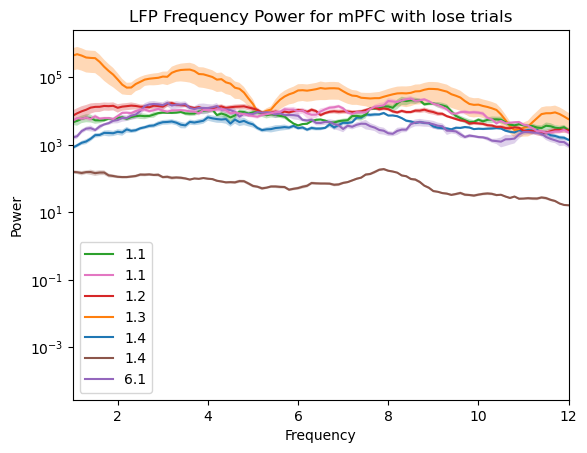

yay!
vHPC
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(26, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(14, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(26, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(28, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(12, 5000)


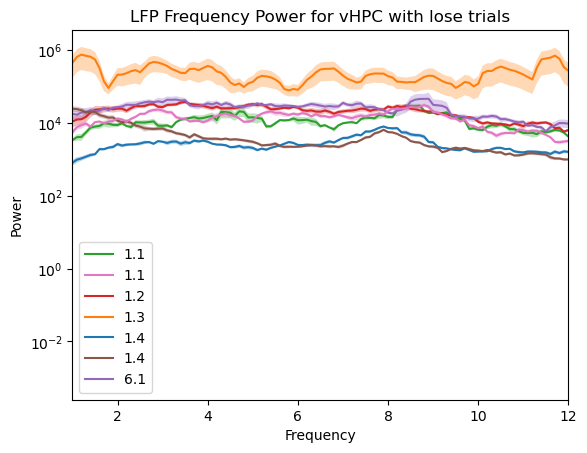

yay!
BLA
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(26, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(14, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(26, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(28, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(12, 5000)


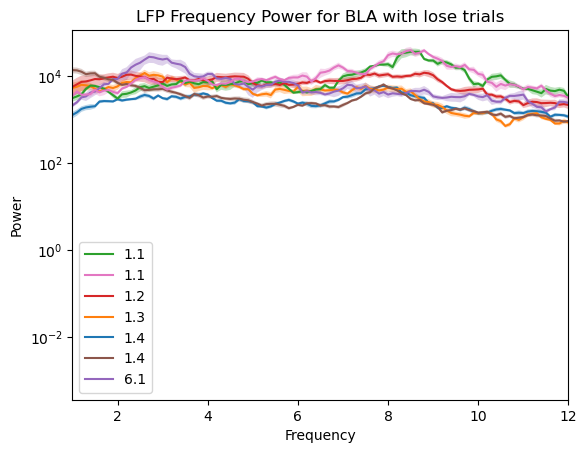

yay!
LH
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(26, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(14, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(26, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(28, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(12, 5000)


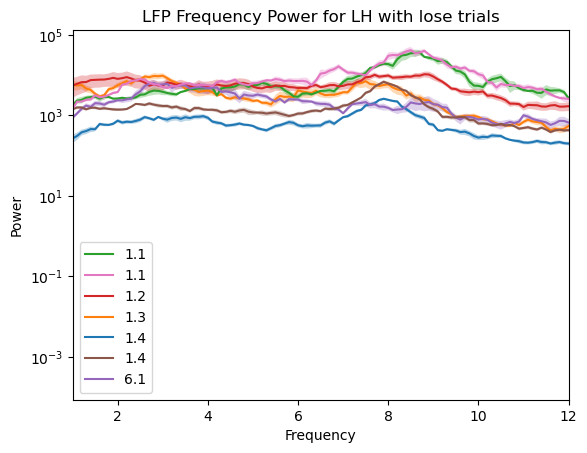

yay!
MD
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(26, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(14, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(26, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(28, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(12, 5000)


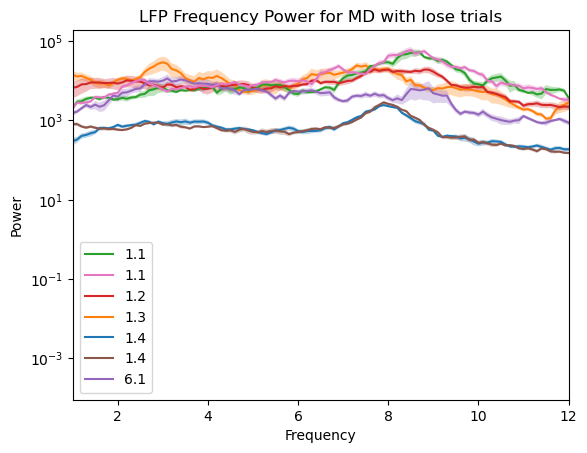

yay!
win
mPFC
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(14, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(13, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(19, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(12, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(28, 5000)


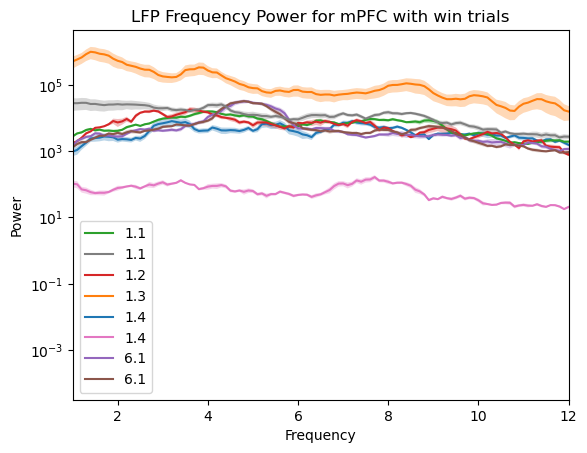

yay!
vHPC
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(14, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(13, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(19, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(12, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(28, 5000)


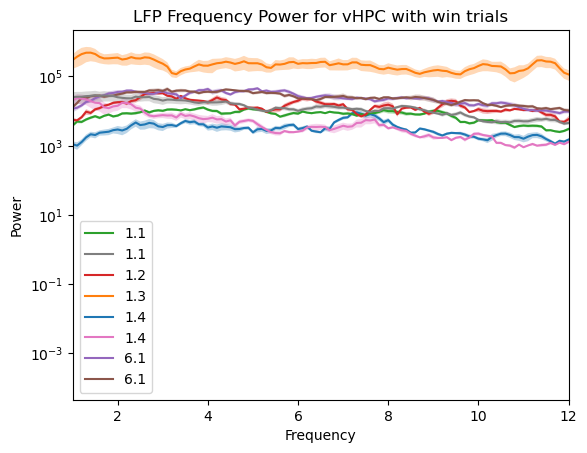

yay!
BLA
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(14, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(13, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(19, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(12, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(28, 5000)


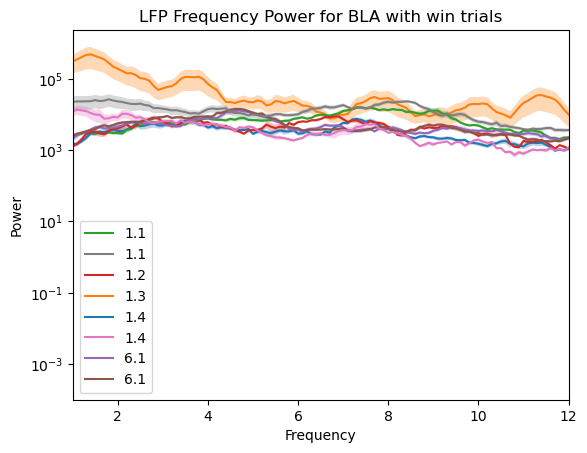

yay!
LH
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(14, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(13, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(19, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(12, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(28, 5000)


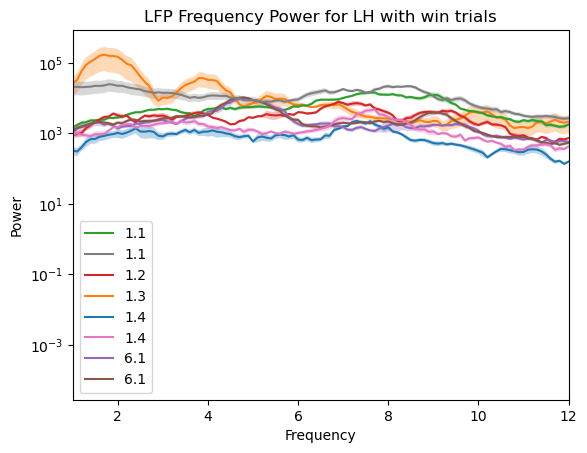

yay!
MD
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(14, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(26, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(13, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(19, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(12, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(28, 5000)


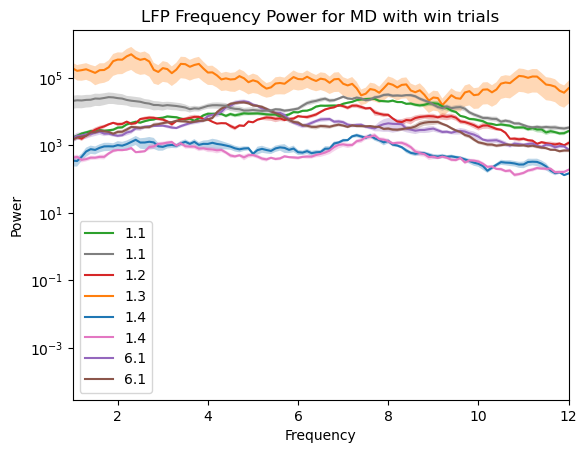

yay!
rewarded
mPFC
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(40, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(40, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(30, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(30, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(11, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(11, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(32, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(30, 5000)


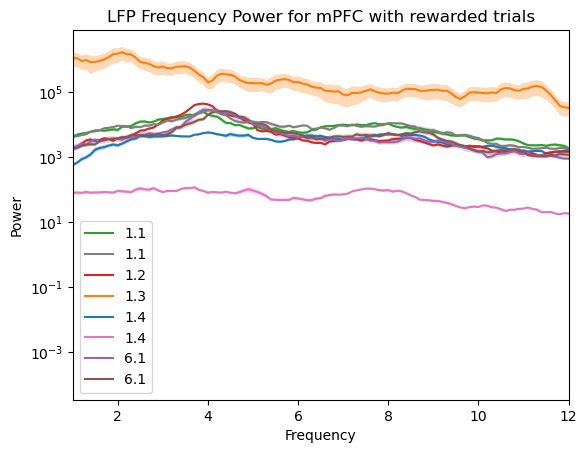

yay!
vHPC
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(40, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(40, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(30, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(30, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(11, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(11, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(32, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(30, 5000)


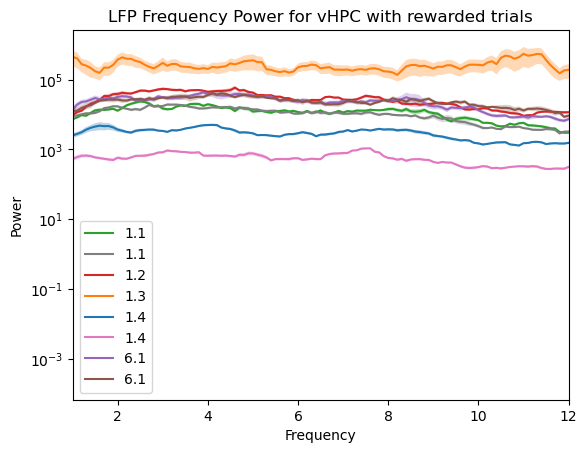

yay!
BLA
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(40, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(40, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(30, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(30, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(11, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(11, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(32, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(30, 5000)


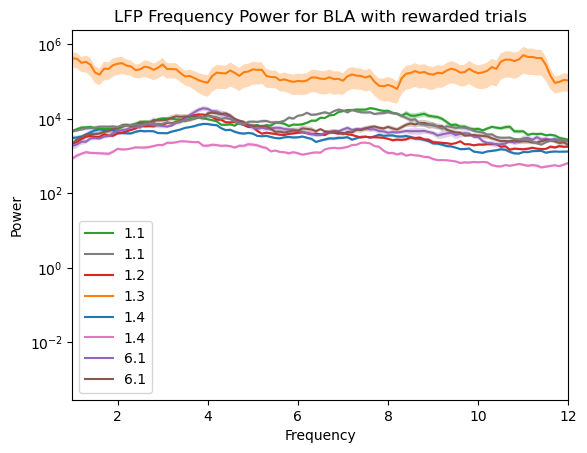

yay!
LH
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(40, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(40, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(30, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(30, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(11, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(11, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(32, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(30, 5000)


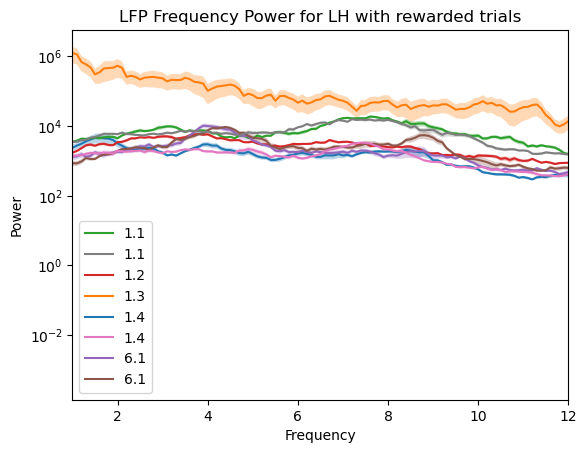

yay!
MD
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
(40, 5000)
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
(40, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(30, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(30, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(11, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(11, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(32, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(30, 5000)


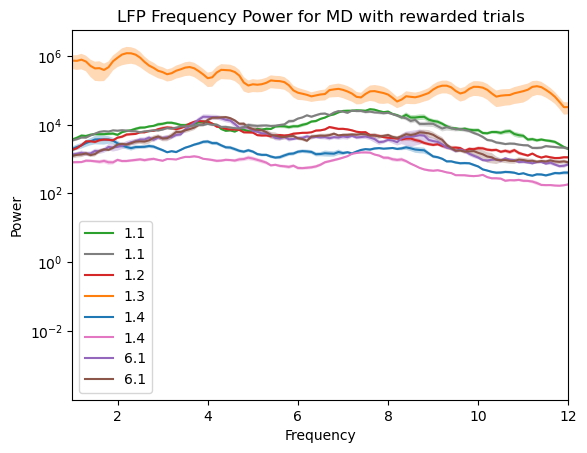

yay!
omission
mPFC
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(3, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(3, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(6, 5000)


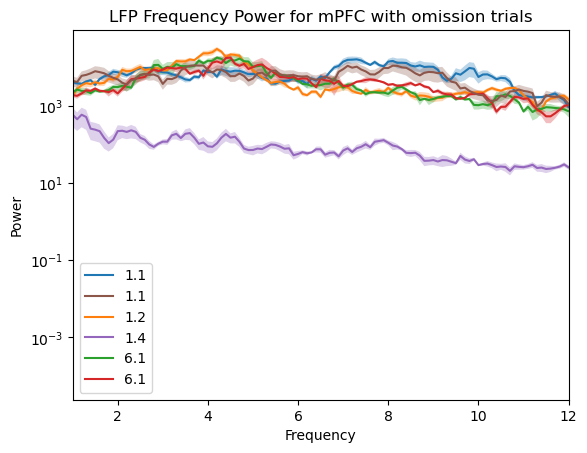

yay!
vHPC
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(3, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(3, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(6, 5000)


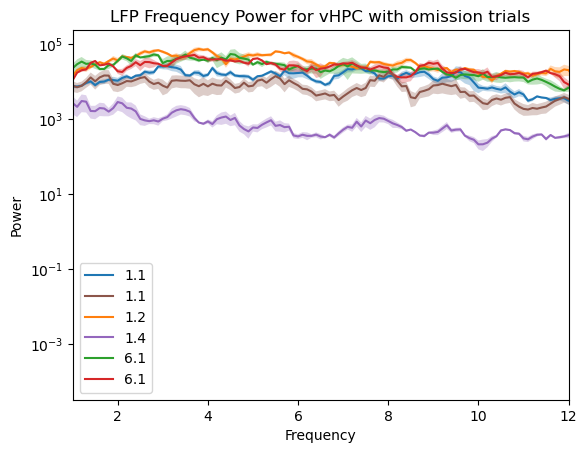

yay!
BLA
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(3, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(3, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(6, 5000)


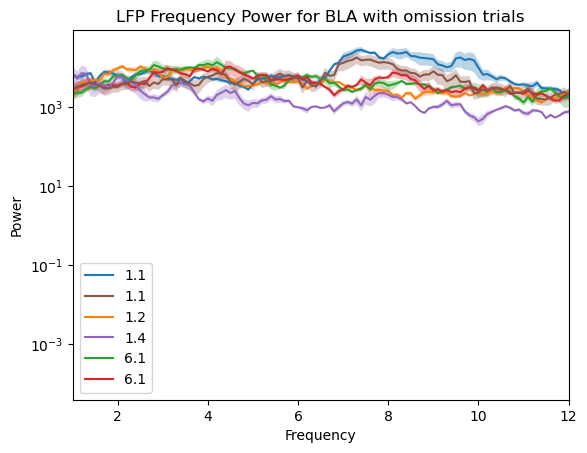

yay!
LH
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(3, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(3, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(6, 5000)


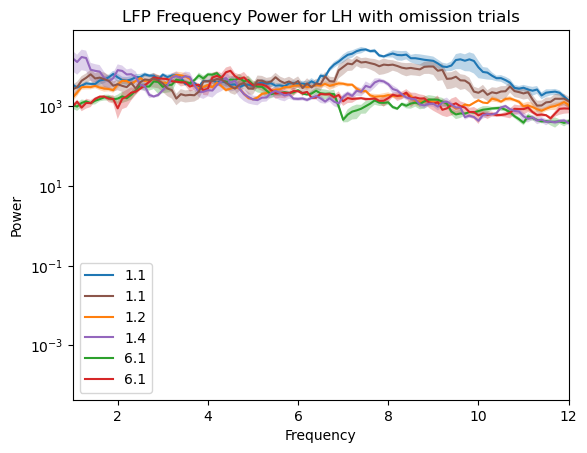

yay!
MD
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
(8, 5000)
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
(8, 5000)
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
(3, 5000)
20221215_145401_comp_amd_om_6_1_top_4_base_3
(3, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
(6, 5000)
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
(6, 5000)


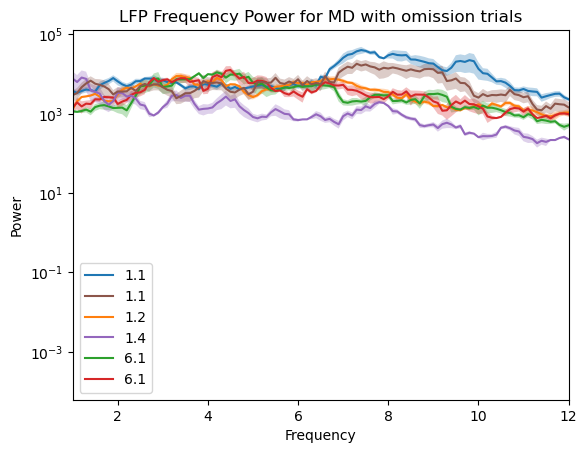

yay!


In [381]:
for outcome, all_region_dicts in condition_to_everything.items():
    print(outcome)
    
    for region, all_recording_dict in all_region_dicts.items():
        print(region)
        
        fig, ax = plt.subplots()
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Power")
        ax.set_xlim(1,12)
        ax.set_yscale('log')
        # labelLines(ax.get_lines(), zorder=2.5)
        plt.title("LFP Frequency Power for {} with {} trials".format(region, outcome))
        for recording, all_trials in all_recording_dict.items():
            if "6_1" in recording:
                subject = "6.1"
            else:
                subject = ".".join(recording.split("subject")[-1].split("subj")[-1].strip("merged").strip("_").replace("-","_").split("_")[:2])
            current_trials = [trials for trials in all_trials if len(trials) == 5000] 
            print(recording)
            print(np.vstack(current_trials).shape)

            mean_power = np.mean(np.vstack(current_trials), axis=0)
            sem_power = np.std(np.vstack(current_trials), axis=0) / np.sqrt(np.vstack(current_trials).shape[0])

            plt.plot(c.frequencies, mean_power, label=subject)
            plt.fill_between(c.frequencies, mean_power - sem_power, mean_power + sem_power, alpha=0.3)
        # Get the handles and labels from the current axes
        handles, labels = plt.gca().get_legend_handles_labels()
        
        # Sort them by labels
        sorted_handles_labels = sorted(zip(handles, labels), key=lambda t: t[1])
        
        # Unzip them back
        sorted_handles, sorted_labels = zip(*sorted_handles_labels)
        
        # Display the legend
        plt.legend(sorted_handles, sorted_labels)
        plt.savefig("./proc/log_lfp_power_{}_{}.png".format(outcome, region))
        plt.show()
        print("yay!")
            




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


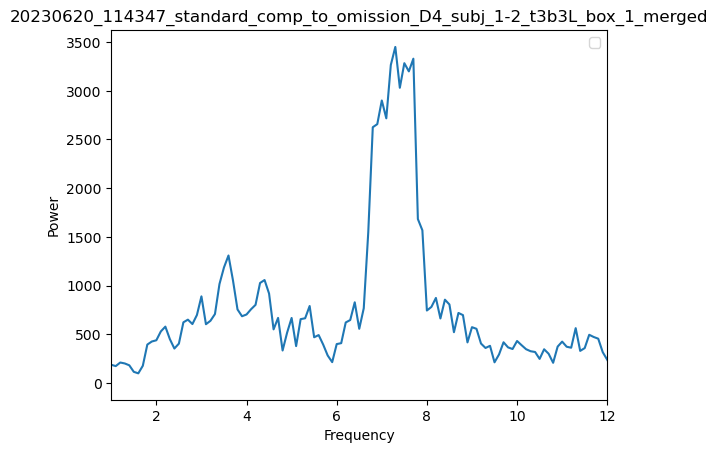

In [107]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.plot(c.frequencies, c.power().squeeze())
ax.set_xlim(1,12)

# labelLines(ax.get_lines(), zorder=2.5)
plt.title(recording_basename)
plt.show()

In [93]:
current_trace.T[0]

array([ -77, -175, -161, ...,   37,  169,  289], dtype=int16)

In [70]:
current_channel_map

Cohort                   2.0
Subject                  1.2
eib_mPFC                 NaN
eib_vHPC                31.0
eib_BLA                 30.0
eib_LH                  29.0
eib_MD                  28.0
spike_interface_mPFC    10.0
spike_interface_vHPC    31.0
spike_interface_BLA     30.0
spike_interface_LH      29.0
spike_interface_MD      28.0
Name: 5, dtype: float64

In [61]:
current_trial_df

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13
0,8260195,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,5757314,20230620_114347_standard_comp_to_omission_D4_s...,5755,1,1-2_t3b3L_box_1,1.2,Subj 2 blocking Subj 1,NaN
1,10060217,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,7557336,20230620_114347_standard_comp_to_omission_D4_s...,7552,1,1-2_t3b3L_box_1,1.1,Subj 1 Only,NaN
2,11160233,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,8657352,20230620_114347_standard_comp_to_omission_D4_s...,8650,1,1-2_t3b3L_box_1,1.1,Subj 1 then Subj 2,1.1 still at port at 8791
3,12160245,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,9657364,20230620_114347_standard_comp_to_omission_D4_s...,9648,1,1-2_t3b3L_box_1,1.1,Subj 1 Only,NaN
4,14060266,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,11557385,20230620_114347_standard_comp_to_omission_D4_s...,11544,1,1-2_t3b3L_box_1,1.1,Subj 1 Only,NaN
5,15560284,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,13057403,20230620_114347_standard_comp_to_omission_D4_s...,13042,1,1-2_t3b3L_box_1,1.2,Subj 2 blocking Subj 1,NaN
6,17660313,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,15157432,20230620_114347_standard_comp_to_omission_D4_s...,15138,1,1-2_t3b3L_box_1,1.1,Subj 1 Only,NaN
7,18660323,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,16157442,20230620_114347_standard_comp_to_omission_D4_s...,16136,1,1-2_t3b3L_box_1,1.1,Subj 2 then Subj 1,1.2 still at port until 16194
8,20260345,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,17757464,20230620_114347_standard_comp_to_omission_D4_s...,17733,1,1-2_t3b3L_box_1,1.2,Subj 2 then Subj 1,1.2 at port unitl 17848
9,21560358,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,19057477,20230620_114347_standard_comp_to_omission_D4_s...,19030,1,1-2_t3b3L_box_1,1.1,Subj 1 Only,NaN


In [38]:
condition_to_brain_region = nested_dict()

In [39]:
for index, row in tone_df.iterrows():
    for brain_region, channel_id in subj_1_1_brain_region_to_channel.items():
        current_trace = subj_1_1_lfp.get_traces(channel_ids=[channel_id], start_frame=row["lfp_index"], end_frame=row["lfp_index"] + 1000 * 10)
        condition_to_brain_region[row["subj_1_1_condition"]][brain_region]["traces"] = current_trace
        
                # Compute multitaper spectral estimate
        m = Multitaper(time_halfbandwidth_product=time_halfbandwidth_product, time_series=current_trace,
                       sampling_frequency=resampled_frequency)
        
        # Sets up computing connectivity measures/power from multitaper spectral estimate
        c = Connectivity.from_multitaper(m)
        
        if condition_to_brain_region[row["subj_1_1_condition"]][brain_region]["c_frequencies"]:
            condition_to_brain_region[row["subj_1_1_condition"]][brain_region]["c_frequencies"].append(c.frequencies)
        else:
            condition_to_brain_region[row["subj_1_1_condition"]][brain_region]["c_frequencies"] = [c.frequencies]

        if condition_to_brain_region[row["subj_1_1_condition"]][brain_region]["c_power"]:
            condition_to_brain_region[row["subj_1_1_condition"]][brain_region]["c_power"].append(c.power().squeeze())
        else:
            condition_to_brain_region[row["subj_1_1_condition"]][brain_region]["c_power"] = [c.power().squeeze()]
